# AUDiaL: Evaluation Report

This notebook outlines the evaluation methodology of [AUDiaL - Accessible Universal Diagrams through Language](https://github.com/tomurillo/AUDiaL) and the conclusions that stem from it.

The current prototype of AUDiaL was evaluated in a number of sessions with blind or almost blind participants. Two sessions took place as part of [ICC 2019](https://www.icc-camp.info/), the International Camp on Communication and Computers. Smaller sessions with one participant each were also conducted with blind participants brought together among students and staff from the [Johannes Kepler University Linz](https://www.jku.at/).

Before starting, let us load the required dependencies and utility methods:

In [1]:
import os
from collections import defaultdict
import operator
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 6]

def print_count_dict(count_dict, total_n=0, indent=0):
    """
    Pretty-print a list of the elements given by count_dict
    """
    unique, counts = np.unique(count_dict, return_counts=True)
    count_sord_idx = np.argsort(-counts)
    for k, v in zip(unique[count_sord_idx], counts[count_sord_idx]):
        line = ' ' * indent
        if indent > 0:
            line += '- '
        line += '{}: {} times'.format(k, v)
        if total_n > 0:
            line += " ({:04.2f}%)".format(v*100/total_n)
        print(line + ".")

## Demographic Data

First, participants were given a short online questionnaire in order to collect demographic data before the evaluation took place. Questions included basic personal information such as age and gender, as well as questions about individual experience and habits browsing the Web and interpreting diagrams.

In [2]:
CSV_DIR = 'data'
DEMO_FILE = 'AUDiaL_demographic_anonymized.csv'
demo_data = np.genfromtxt(os.path.join(CSV_DIR, DEMO_FILE), dtype=None, delimiter=',', names=True, encoding=None)
N = demo_data.shape[0]
print('N={} participants.'.format(N))

N=9 participants.


### Age

In [3]:
ages = demo_data[:]['Age']
print('Range: {} to {} years.'.format(np.min(ages), np.max(ages)))
print('Average: {:05.2f} years.'.format(np.mean(ages)))
print('Standard deviation: {:05.2f} years.'.format(np.std(ages)))

Range: 17 to 58 years.
Average: 24.11 years.
Standard deviation: 12.17 years.


### Gender

In [4]:
gender = demo_data[:]['Gender']
male = (gender == 'M').sum()
female = (gender == 'F').sum()
print('Male: {} times ({:04.2f}%).'.format(male, male*100/N))
print('Female: {} times ({:04.2f}%).'.format(female, female*100/N))

Male: 4 times (44.44%).
Female: 5 times (55.56%).


### Visual Impairement

Participants were asked two questions regarding their visual impairement, namely:
<ol>
    <li>
        Which of the following describes you best?
        <ul>
            <li>I am totally blind</li>
            <li>I have near total blindness</li>
            <li>I have profound low vision</li>
            <li>I have severe low vision</li>
            <li>I have moderate low vision</li>
            <li>I have near-normal vision</li>
            <li>I have normal vision</li>
        </ul>
    </li>
    <li>
        (If they chose one of the first two answers on the first question) Since when are you blind?
        <ul>
            <li>I am blind from birth</li>
            <li>I have been blind for more than 10 years</li>
            <li>I have been blind for between 5 and 10 years</li>
            <li>I have been blind for between 1 and 5 years</li>
            <li>I have been blind for less than 1 year</li>
        </ul>
    </li>
</ol>

In [5]:
blind = demo_data[:]['Sight']
print_count_dict(blind, N)

Blind: 7 times (77.78%).
Near Blind: 2 times (22.22%).


In [6]:
blind_since = demo_data[:]['Blind_since']
print('Blind since:')
print_count_dict(blind_since, N, indent=2)

Blind since:
  - Birth: 8 times (88.89%).
  - more than 10 years: 1 times (11.11%).


### Web Browsing Habits

Next, participants were asked to answer three questions related to the ways they surf the Web in their daily lives. These questions were included in order to assess whether participants presented any hindrances that may obstruct their use of the Web tool employed during the evaluation, such as lack of experience browsing web pages or being accustomed to assistive technologies not available in the session room.

<ol>
    <li>
        How long (approximately) have you been browsing Web pages?
        <ul>
            <li>I have no experience browsing the Web</li>
            <li>Less than 1 year</li>
            <li>Between 1 and 5 years</li>
            <li>Between 5 and 10 years</li>
            <li>More than 10 years</li>
        </ul>
    </li>
    <li>
        How do you browse Web pages? (choose all that apply):
        <ul>
            <li>Screen reader and text-to-speech software</li>
            <li>Screen reader and a Braille display</li>
            <li>Screen magnifier software</li>
            <li>Other assistive technologies</li>
            <li>I do not use assistive technologies</li>
        </ul>
    </li>
    <li>Which screen reader (if any) do you use?</li>
</ol>

In [7]:
wb_exp = demo_data[:]['Web_Browsing_Experience']
print('Web browsing experience:')
print_count_dict(wb_exp, N, indent=2)

Web browsing experience:
  - more than 5 years: 6 times (66.67%).
  - more than 10 years: 3 times (33.33%).


In [8]:
ass_tech_raw = demo_data[:]['Browsing_Habit']
print('Assistive Technologies (combined counts):')
print_count_dict(ass_tech_raw, N, indent=2)

Assistive Technologies (combined counts):
  - TTS; Braille: 4 times (44.44%).
  - Braille: 2 times (22.22%).
  - TTS: 2 times (22.22%).
  - TTS; Magnifier: 1 times (11.11%).


In [9]:
ass_tech_names = ['TTS', 'Braille', 'Magnifier']
ass_tech = defaultdict(int)
for t in ass_tech_raw:
    for n in ass_tech_names:
        if n in t:
            ass_tech[n] += 1
print('Assistive Technologies (unique counts):')
for t, n in ass_tech.items():
    print('  - {}: {} times ({:04.2f}%)'.format(t, n, n*100/N))

Assistive Technologies (unique counts):
  - TTS: 7 times (77.78%)
  - Braille: 6 times (66.67%)
  - Magnifier: 1 times (11.11%)


In [10]:
sreader_raw = demo_data[:]['Screen_Reader']
sreader_raw_split = []
for s in sreader_raw:
    sreader_raw_split.extend(s.split(';'))
sreaders_names = ['nvda', 'jaws', 'voiceover']
sreaders = defaultdict(int)
for sr in sreader_raw_split:
    sr_norm = sr.lower().strip()
    if sr_norm in sreaders_names:
        sreaders[sr_norm] += 1
print('Screen Readers:')
for s, n in sreaders.items():
    print('  - {}: {} times ({:04.2f}%)'.format(s, n, n*100/N))

Screen Readers:
  - jaws: 5 times (55.56%)
  - nvda: 8 times (88.89%)
  - voiceover: 1 times (11.11%)


### Diagram Knowledge and Experience

Lastly, participants were asked about their knowledge on diagrams, common accessibility features of diagrams they encounter online, and their preferred means of accessing diagrams.

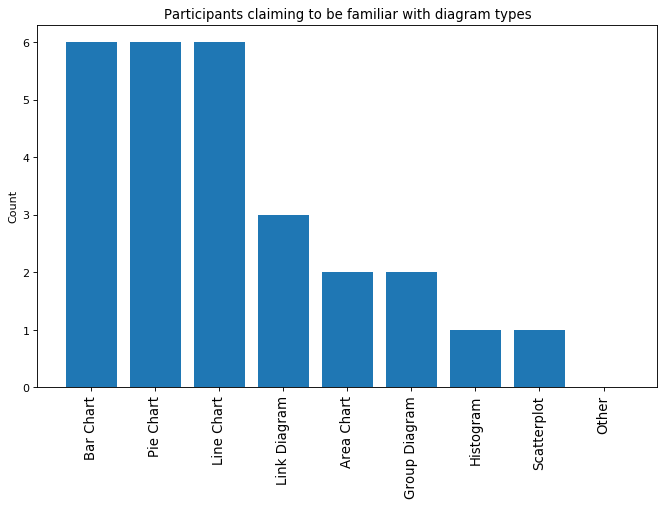

In [11]:
diag_names = ['Bar_Chart', 'Histogram', 'Pie_Chart', 'Line_Chart', 'Scatterplot', 'Area_Chart', 'Link_Diag', 'Group_Diag', 'Other']
diag_counts = {}
for d in diag_names:
    diag_counts[d] = (demo_data[:][d] == 'Y').sum()
diag_counts_sort = sorted(diag_counts.items(), key=operator.itemgetter(1), reverse=True)
x = np.arange(len(diag_names))
y = []
xticks = []
for k, v in diag_counts_sort:
    y.append(v)
    xticks.append(k.replace('_', ' ').replace('Diag', 'Diagram'))
fig = plt.figure(figsize=(10, 6), dpi=80, facecolor='w', edgecolor='k')
plt.bar(x, y)
plt.xticks(x, xticks)
plt.xticks(fontsize=12, rotation=90)
plt.ylabel('Count')
plt.title('Participants claiming to be familiar with diagram types')
plt.show()

In [12]:
diag_freq = demo_data[:]['Diagram_Frequency']
print('Frequency with which diagrams are encountered on websites:')
print_count_dict(diag_freq, N, indent=2)

Frequency with which diagrams are encountered on websites:
  - <15% of Websites: 5 times (55.56%).
  - Almost Never: 2 times (22.22%).
  - <5% of Websites: 1 times (11.11%).
  - Never: 1 times (11.11%).


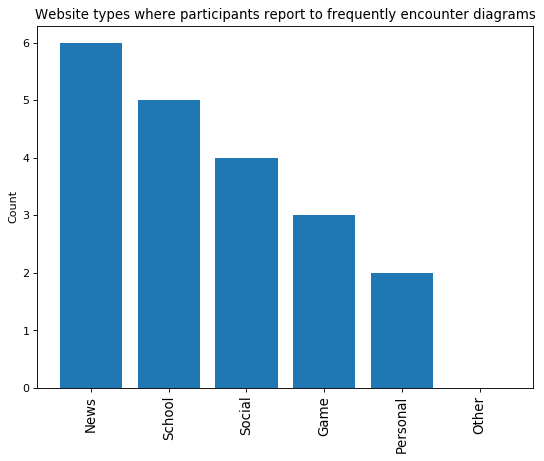

In [13]:
web_names = ['News', 'School', 'Social', 'Personal', 'Game', 'Other']
web_counts = {}
for n in web_names:
    web_counts[n] = (demo_data[:][n] == 'Y').sum()
web_counts_sort = sorted(web_counts.items(), key=operator.itemgetter(1), reverse=True)
x = np.arange(len(web_names))
y = []
xticks = []
for k, v in web_counts_sort:
    y.append(v)
    xticks.append(k)
fig = plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.bar(x, y)
plt.xticks(x, xticks)
plt.xticks(fontsize=12, rotation=90)
plt.ylabel('Count')
plt.title('Website types where participants report to frequently encounter diagrams')
plt.show()

In [14]:
alt_freq = demo_data[:]['Alt_Text']
print('Frequency with which an alt-text attribute is encountered on online diagrams:')
print_count_dict(alt_freq, N, indent=2)

Frequency with which an alt-text attribute is encountered on online diagrams:
  - Almost never: 3 times (33.33%).
  - Never: 3 times (33.33%).
  - Sometimes: 2 times (22.22%).
  - Most times: 1 times (11.11%).


In [15]:
longdesc_freq = demo_data[:]['Longdesc']
print('Frequency with which a long description accompanies online diagrams:')
print_count_dict(longdesc_freq, N, indent=2)

Frequency with which a long description accompanies online diagrams:
  - Almost never: 5 times (55.56%).
  - Never: 4 times (44.44%).


In [16]:
tactile_freq = demo_data[:]['Tactile_Freq']
print('Frequency with tactile diagrams are read:')
print_count_dict(tactile_freq, N, indent=2)

Frequency with tactile diagrams are read:
  - <5 times: 3 times (33.33%).
  - Few times/year: 3 times (33.33%).
  - Never: 2 times (22.22%).
  - <10 times: 1 times (11.11%).


In [17]:
alt_preferred = demo_data[:]['Preferred_alt']
print('Preferred alternative means for accessing diagrams:')
print_count_dict(alt_preferred, N, indent=2)

Preferred alternative means for accessing diagrams:
  - Text description: 5 times (55.56%).
  - Table: 2 times (22.22%).
  - Tactile copy: 2 times (22.22%).
